# CAB420 Clustering (and Classification), Bonus Example: Bag of Visual Words
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

A while back, we mentioned this thing called "Bag of Words". This is a text processing method, and the idea is that rather than look at some piece of text as a sequence of words and consider it "in order" (which brings all sorts of constraints, like requiring us to have sequences all be the same length, and meaning that the position of words becomes potentially restrictive), we simply count how many times each word occurs and use the resulting histogram as our feature. This means that:
* Any sized input will get transformed to the same length, based on the size of our dictionary (i.e. how many words we have)
* Any order information is lost

In this example we're going to apply the same idea to image data. The trick is to get some *visual words*, which will allow us to replicate the text pipeline, including adding all the bells and whistles such as TF-IDF transforms and the like.

### Getting Visual Words

*Visual Words* are where clustering comes in. What we're going to do is:
* Extract a bunch of local features from our images. These will essentially describe the image content in a small region. Usually this will be based on texture in some way. We'll use HOG here.
* Cluster those features using k-means. This will find $N$ representitive features, or *Visual Words*, that can be used to describe the type of local textures that we're seeing.

We'll call this k-means model, or really the set of cluster centres that we get from it, our *codebook*. This defines our set of visual words.

Using a larger value of $N$ will give us a more descriptive (i.e. larger) set of visual words. Though if we have too many we many end up with multiple words effectivley representing the same texture (i.e. overclustering), and a feature dimension that ends up being very large. Using a small value of $N$ will have give us problems, we may fail to separate out different patterns, and may end up with a feature descriptor that does not capture the differences that we need to find.

### Applying BoVW

The BoVW pipeline is a bit of multi-step affair. What we're going to do is:
* Train a *codebook* to learn some visual words. This itself will involve
  * Transform some data using a local feature extractor, in our case HOG. Here, we'll focus on getting features for small images patches, rather than getting one large feature for an image
  * Fit k-means clustering to that HOG data
* Transform our training and testing sets using the codebook. This will involve:
  * For each image, transform it into local HOG features
  * Assign the resultant HOG features to clusters using the learned k-means cluster centres
* Train a classifier using the data that has been transformed through the codebook

### Why K-Means?

It's not a great clustering method. It has limitations, and I've talked it down a fair bit. Why use it here?
* We need to be able to learn some cluster centres, and then fit new data to those clusters. This rules out things like HAC and DBScan.
* We don't need partial assignments, or any other fancy things. We just want to be able to say "this texture here is most like this cluster centre", and then just count up instances.
* We've probably got a lot of data, and so speed is a consideration. K-means will be nice and quick.
* The whole "spherical clusters" thing that I usually complain about is actually kind-of useful here. It ensures that I get clusters that are distrbuted somewhat evenly across the dataspace. Some clusters will be bigger than others, but (provided I have sufficient clusters) most patches will have a fairly similar looking cluster (codeword) that is learned by k-means.

### Where does this fit into all the other CAB420 content?

This example combines ideas from a few places. In particular:
* Bag of Words, which is adapted to visual features here
* The Histogram of Oriented Gradidents bonus example, though other local feature descriptors are equally applicable here
* Clustering, and in particular K-means, which is used to build the codebook
* Our non-deep learning classification methods

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans

## The Data

This has been directly copied from the earlier HOG Bonus example. We're using the same rock, paper, scissors dataset.

**NOTE: As this has been copied from the HOG Bonus Example, we have the same JupyterLab memory issue. If you are using JupyterLab, uncomment the two lines below that apply the resize function to the data via map.**

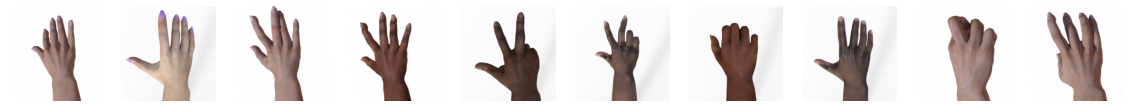

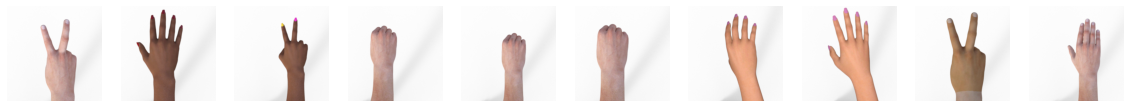

In [2]:
# simple resize function to shrink our images
def resize(image, label):
    image = tf.image.resize(image,[100,100])
    return (image,label)

# convert the contents of a tfds to a couple of numpy arrays
def convert_to_numpy(ds):
    
    x = []
    y = []

    # loop through the dataste
    for im,l in ds:
        # add the images and their labels to x and y lists
        x.append(im)
        y.append(l)

    # convert lists to arrays
    x = np.array(x)
    y = np.array(y)
    # convert the images to a float, and scale by 1/255
    x = (x.astype(np.float32) / 255.0)
    
    # return the newly converted x and y
    return x, y

# load a tdfs dataset, and convert it to numpy
def load_tfds(dataset):
    # load the data
    (ds_train, ds_test), ds_info = tfds.load(
        dataset,
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    
    #
    # NOTE: This is only needed for the JupyterLab environment to avoid running out of 
    # memory and having the kernal die. If you are on jupyter lab, add these two lines
    # in
    #
    #ds_train = ds_train.map(resize)
    #ds_test = ds_test.map(resize)
    
    # convert to numpy
    x_train, y_train = convert_to_numpy(ds_train)
    x_test, y_test = convert_to_numpy(ds_test)

    # return the numpy version of the data
    return (x_train, y_train), (x_test, y_test)

# pictures, lots of pictures
def display_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, :], cmap='gray')
        ax[i].axis('off')
    plt.show()

# vectorise images, convert each image to a vector
def vectorise_images(images):
    return np.reshape(images, (images.shape[0], -1))

# load the data
(x_train, y_train), (x_test, y_test) = load_tfds('rock_paper_scissors')

# display the first 10 images of the train and test sets
display_images(x_train, 10)
display_images(x_test, 10)

## Local HOG Features

Last time we visited HOG-land, we were getting one feature for the entire image. This feature captured the texture in local patches across the entire image. Now, we want to get those features that describle local patches. Remember that with HOG what we're doing is getting a description of the local textures. We're breaking the image into *cells*, and then for each cell getting a histogram of oriented gradients. We're then grouping these into *blocks*. 

Each *block* is capturing the local texture in one region. We can make this more detailed by either increasing the number of `cells_per_block`, or the number of `orientations`.

We'll call the HOG function in the same way we did last time, but this time set `feature_vector=False`.

In [3]:
# call HOG. Now that now feature_vector=False, which means that we'll get the features for each small patch.
# We've also got visualise=False as we're not going to worry about plotting HOG here.
hog_data = hog(x_train[4,:,:,:], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=False, channel_axis=2, feature_vector=False)
print(hog_data.shape)

(17, 17, 2, 2, 8)


With `feature_vector=False`, we get a very different output shape here to what we've had before. We pull out blocks from the image, sliding across the image vertically and horizontally, obtaining all up $17 \times 17$ blocks. Each block is made up of $2 \times 2$ cells, each of which has $8$ orientations. This means that for a single image, we have $289$ ($17 \times 17$) size $32$ ($2 \times 2 \times 8$) features.

In [4]:
features = np.reshape(hog_data, (-1, 2*2*8))

In [5]:
print(features.shape)

(289, 32)


## Bag of Visual Words (BoVW)

I've got three functions below. The third one should be very familar by now, so we'll ignore it, but the first two deserve a bit of discussion.

### Building the Codebook

`build_codebook` is going to find our words. It will take in a bunch of raw images, extract some local features from them (we'll use HOG), and then cluster these using k-means. The resultant cluster centres are our visual words. We can view these are being some set of typical textures; and k-means being what it is with it's spherical clusters, these cluster centres will be distributed somewhat uniformly across the dataspace. This function will return the trained k-means object, which we can then use to encode images into our BoVW representation.

### Mapping data to BoVW

Once we've got a set of visual words, `transform_dataset_to_bovw` will transform data from raw images into bags of these words.

This function will take in a bunch of images and for each image will:
* Transform it to a set of local HOG features
* Convert those into codewords via the provided codebook (i.e k-means model)
* Compute a histogram of the codewords, getting the bag of words representation

The function will then return a matrix with all of the images converted into the BoVW representation.

In [6]:
# Learn a codebook. This will transform some data into local HOG features, and then learn a codebook
# from that transformed data. n_codewords will determine the size of the codebook (i.e. this is K in 
# our k-means).
def build_codebook(n_codewords, data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # storage for the HOG data
    hog_data = []
    # extract HOG data for each image
    for im in range(data.shape[0]):
        hog_data.append(np.reshape(hog(data[im, :, :, :], orientations=orientations, \
                                       pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, \
                                       visualize=False, channel_axis=2, feature_vector=False),\
                                   (-1, cells_per_block[0]*cells_per_block[1]*orientations)))
    # reshape the HOG data
    hog_data = np.reshape(np.array(hog_data), (-1, cells_per_block[0]*cells_per_block[1]*orientations))
    # fit the k-means model
    kmeans = KMeans(n_clusters=n_codewords, random_state=4, n_init='auto').fit(hog_data)
    # return the fitted k-means, this is our codebook
    return kmeans

# Transform some raw image data into bag-of-visual-words data. This transform a raw image into local hog
# features, and then use the provided codebook to transform these HOG features into visual words. Finally, we'll
# build a histogram of these visual words
def transform_dataset_to_bovw(codebook, data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # storage for bag of visual word features
    bovw_data = []
    # loop through the images
    for im in range(data.shape[0]):
        # first transform the image into local hog featuers
        hog_data = np.reshape(hog(data[im, :, :, :], orientations=orientations, \
                             pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, \
                             visualize=False, channel_axis=2, feature_vector=False),\
                         (-1, cells_per_block[0]*cells_per_block[1]*orientations))        
        # pass those features through the codebook to get the visual words
        vw = codebook.predict(hog_data)
        # count the visual words, getting a histogram of word occurances
        b, _ = np.histogram(vw, bins=range(codebook.cluster_centers_.shape[0] + 1))
        bovw_data.append(b)
        
    return np.array(bovw_data)

# A suspiciously familiar looking eval function. This will:
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

First up, let's train a codebook. This is the part that's going to take a while. To make this a bit less of a pain, I'm not going to use all of the training data.

I will note that using more training data is better here as I'll get a better set of codewords that better represent the data as a whole.

In [7]:
codebook = build_codebook(1000, x_train[0:100,:,:,:])

Once we've got the codebook, we can convert all of our data.

In [8]:
x_train_bovw = transform_dataset_to_bovw(codebook, x_train)
x_test_bovw = transform_dataset_to_bovw(codebook, x_test)

And then we can fit a classifier. Note that I'm going to use a linear SVM here. This is fairly typical of BoVW as we normally have fairly sparse features (i.e. they contain a lot of 0's), and linear SVMs generally like sparse data. Keep in mind that as is often the case in these examples, I'm not going to worry about finding the best SVM parameters. I'll select a kernel that makes sense for the data, and then run with other parameters (in this case C) being the defaults. If I was doing this for a real-world system, I'd spend some time finding the best value of C on a validation set via a grid search.

The SVM with HOG took 0 seconds to train and 0 seconds to eval.


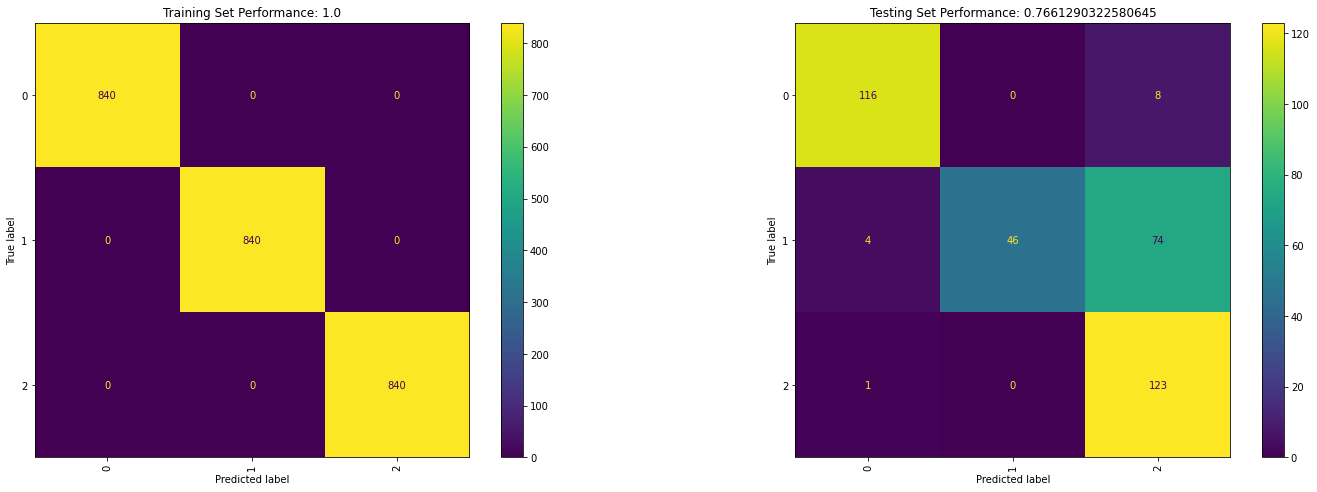

In [9]:
svm_start = time.process_time()
hog_svm = SVC(kernel='linear').fit(x_train_bovw, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_bovw, y_train, x_test_bovw, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

## Codebook Size

Let's try a few codebook sizes. Like any other clustering problem, we can undercluster, or overcluster. Underclustring will mean that local features that should be distinct, i.e. truly represent different things, are in fact being grouped in the one cluster. Overclustering is going the other way, with features that really belong together being split across multiple clusters.

In practice, there's no easy way to tell what our codebook size should be; and any heuristic that we'd like to use is likely going to be very slow to analyse due to the very large number of features that we have to cluster. Often, the codebook size is simply another parameter that is evaluated in a grid search alongside any model parameters that need to be tuned.

The SVM with HOG took 0 seconds to train and 0 seconds to eval.


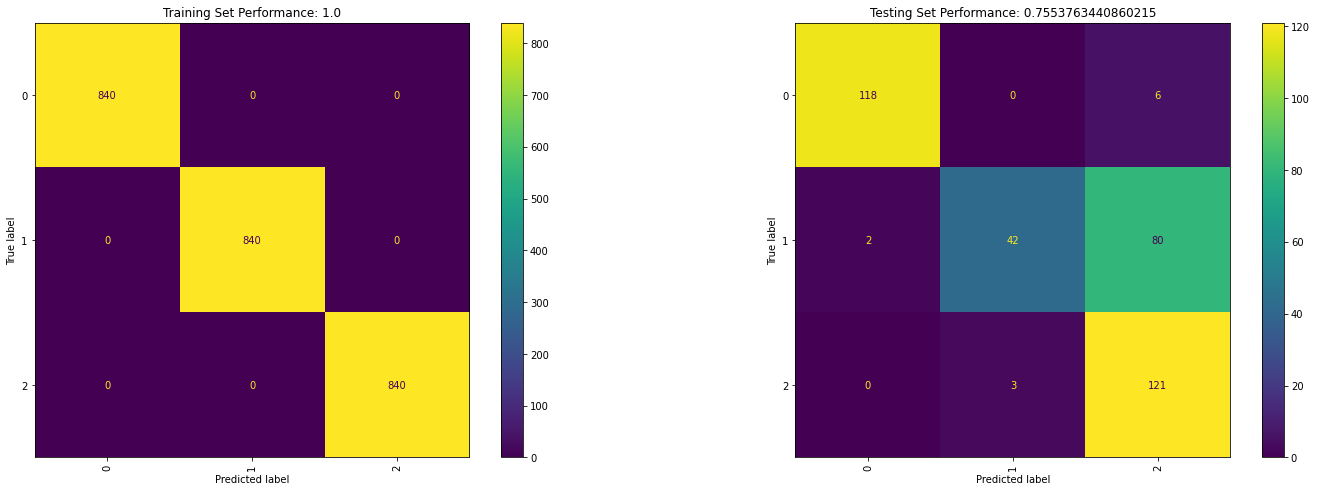

In [10]:
codebook = build_codebook(100, x_train[0:100,:,:,:])
x_train_bovw = transform_dataset_to_bovw(codebook, x_train)
x_test_bovw = transform_dataset_to_bovw(codebook, x_test)

svm_start = time.process_time()
hog_svm = SVC(kernel='linear').fit(x_train_bovw, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_bovw, y_train, x_test_bovw, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

The SVM with HOG took 0 seconds to train and 0 seconds to eval.


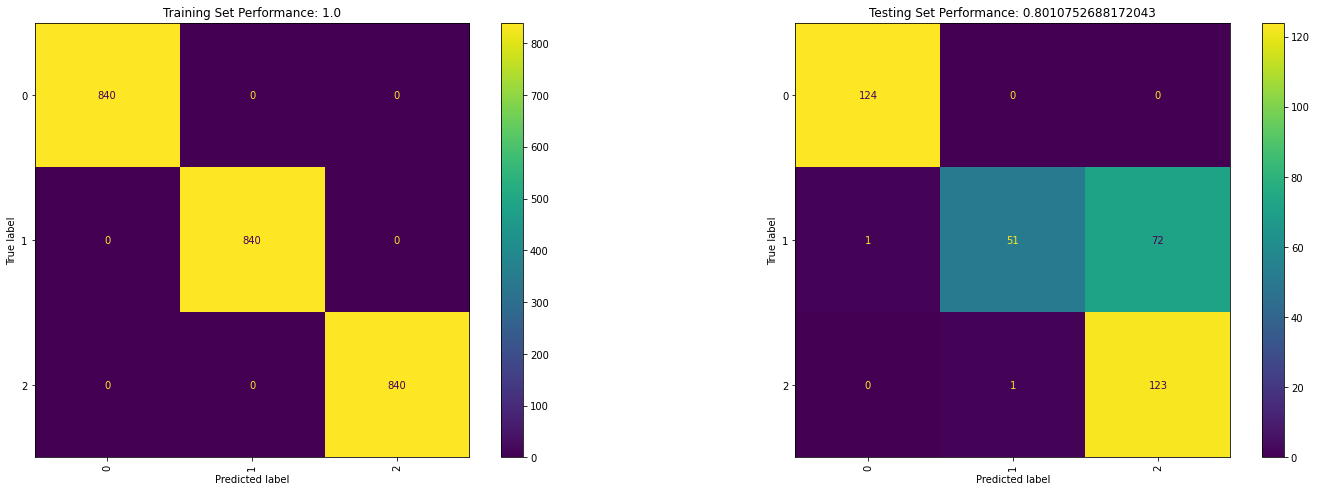

In [11]:
codebook = build_codebook(250, x_train[0:100,:,:,:])
x_train_bovw = transform_dataset_to_bovw(codebook, x_train)
x_test_bovw = transform_dataset_to_bovw(codebook, x_test)

svm_start = time.process_time()
hog_svm = SVC(kernel='linear').fit(x_train_bovw, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_bovw, y_train, x_test_bovw, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

The SVM with HOG took 6 seconds to train and 21 seconds to eval.


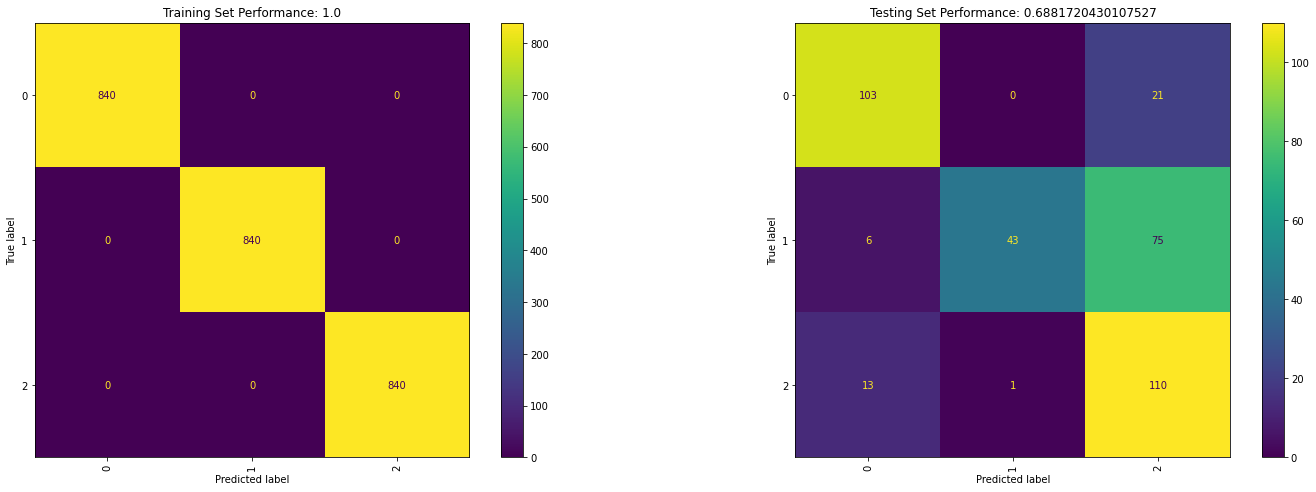

In [12]:
codebook = build_codebook(4000, x_train[0:100,:,:,:])
x_train_bovw = transform_dataset_to_bovw(codebook, x_train)
x_test_bovw = transform_dataset_to_bovw(codebook, x_test)

svm_start = time.process_time()
hog_svm = SVC(kernel='linear').fit(x_train_bovw, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_bovw, y_train, x_test_bovw, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

Considering the above, it's hard to read too much into these results as we're not optimising the value of C in the SVM, but seeing a drop in performance with a smaller codebook, where we are likely grouping things that should be separate; and then with a much larger codebook where we're separating things that should not be separated, is not a surprise.

Certainly though, you can see how changing the codebook size can lead to a large change in performance.

## Final Thoughts

The above has hopefully illustrated what goes into a bag-of-visual-words model. Really, this is no different to bag-of-words once you work out what the actual words are. For this, we use k-means to find a set of representitive textures based on local features. These local features could be anything (SIFT is another really common option for example), and by changing this features to something that extracts features from video (i.e. extracts spatio-temporal features) we can use this same method to classify things in videos.

Once we've got the words, the same things that we do with text, like using TF-IDF, can be used here (and can work equally well).

### BoVW vs using HOG features directly

Looking at the above, a question that may occur is "Why bother? Why not just use the HOG features directly?" There are a few reasons:
* Using BoVW will (or at least often does) lead to a more compact representation, which makes the task of actually learning the classifier a bit quicker and easier.
* Using BoVW will result in sparse feature vectors, which work well with things like linear SVMs. The feature vectors that you obtain from the feature extraction method itself will generally be a lot denser.
* From BoWV, you can then use other methods such as TF-IDF to help highlight distinct features, which can in turn help classification.
* Using BoVW you get some invarainces. In particular, you get location invariance. Like BoW throws away the order of words, BoVW throws away the order of patches. This is bad if you are explicitly looking for a feature to be in the top-left corner - but this is actually rarely the case. Usually, we are looking for something which can occur anywhere in the image. Having a representation that is invariant to location/translation is, as such, often a good thing.